0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08


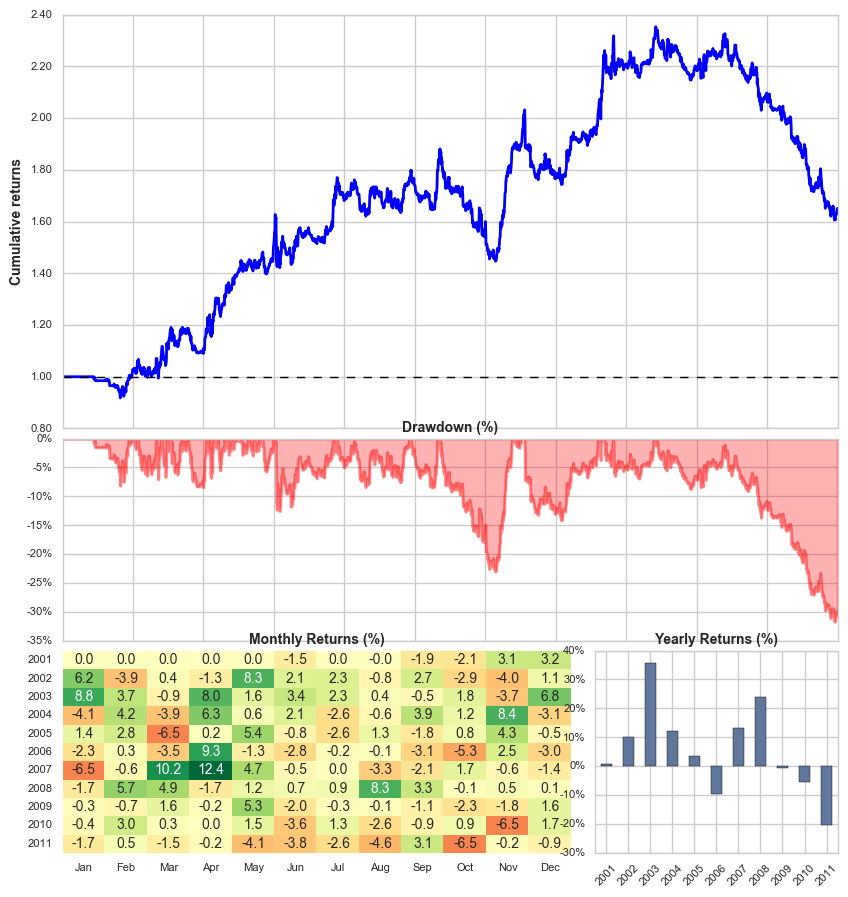

,Base Stats
#Trades,850.000000
CAGR(%),4.586957
Avg trade(R),0.070788
Daily Sharpe,0.422172


In [1]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.data_handlers.arctic_data_handler import ArcticDatabaseDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from Engine.backtest_engine import BacktestEngine
from broker.account import SimulatedAccount
from trade_store.mongo_data_store import MongoTradeStore


from strategy_manager import StrategyManager

from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_2 import RSI_Trading_Strategy
from strategies.PA_test import PA_Test

%matplotlib inline

#PARAMETERS
symbol_list= ['EURUSD','GBPUSD','AUDUSD','USDCAD']
risk= 0.01
equity = 1000.0
leverage = 20
start_date= datetime(2001,1,1)
end_date= datetime(2011,12,31)


events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')

prices= ArcticDatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')

strategy_3 = DonchianBreakout(prices,events_queue, entry_lookback=100, exit_lookback=50, atr_stop=3.,TP_atr=5.,name='DC_100x50')
strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=15, rsi_trigger_offset=25,trailing_stop_atr=1.8, take_profit_atr=3)
strategy_6 = PA_Test(prices,events_queue,atr_stop=1.8,TP_atr=4.)

manager = StrategyManager([strategy_3,strategy_5,strategy_6])

store = MongoTradeStore(db_name='TRADES')

portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strat_manager=manager,risk_per_trade = risk,data_store=store)
portfolio.open_trades.clear()
portfolio.compound=False

execution = SimulatedExecution(events_queue,prices,spread=0.0003)
backtest = BacktestEngine(events_queue, prices, execution, portfolio, manager)

backtest.run()
backtest.stats.plot_results()
backtest.stats.output_base_stats()

# Backtest Analysis

In [2]:
backtest.stats.get_results()

,All Trades,Long only,Short only
#Trades,850,422,428
CAGR(%),4.58696,NaN,NaN
Avg trade(R),0.0707885,0.19283,-0.0495585
Daily Sharpe,0.422172,NaN,NaN
Max Drawdown(%),31.7583,NaN,NaN
Avg Duration,19 days 07:54:21.176470,18 days 18:05:07.109004,19 days 21:31:57.757009
Exposure %,93.3473,43.1022,50.2451
Win Rate %,41.5294,0.466825,0.364486
Avg Win,1.66243,1.61352,1.72418
Avg Loss,-1.05969,-1.05107,-1.06685


In [3]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)
print('Avg trades_per_years',trades_per_years.mean())

Cost efficiency 0.06
Avg trades_per_years 77.27272727272727


In [4]:
print("R-squared %0.2f" %backtest.stats.r_squared)

R-squared 0.80


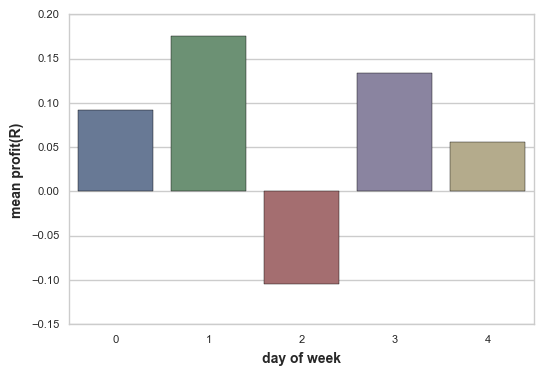

In [5]:
import seaborn as sns
import pandas as pd

df_weekday = trades[['open_date','close_date','profit_R']].reset_index()
df_weekday['open_weekday']=df_weekday.open_date.dt.dayofweek
df_weekday['close_weekday']=df_weekday.close_date.dt.dayofweek
weekday_group = df_weekday.groupby(by='open_weekday')

results = pd.DataFrame(index = weekday_group.profit_R.sum().index)
results['mean'] = weekday_group.profit_R.mean()
sns.barplot(x=results.index,y='mean',data=results)
sns.axlabel(xlabel='day of week',ylabel='mean profit(R)')

# Strategies analysis

In [6]:
strat_equities = pd.DataFrame()
trades['returns'] = trades.profit_R * risk

for key,strategy in manager.strategies.items():
    name = strategy.identifier
    equity = (1+trades.profit_R[trades.strategy == name]).cumprod()
    strat_equities = pd.concat([strat_equities,equity],axis=1)
strat_equities.fillna(method='pad',inplace=True)

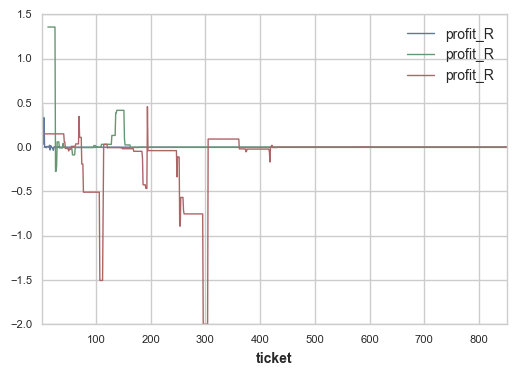

In [7]:
strat_equities.plot()